# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [8]:
!pip install subword_nmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/data.txt

--2023-04-19 10:29:49--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905335 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2023-04-19 10:29:49 (126 MB/s) - ‘data.txt’ saved [12905335/12905335]



In [10]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:22<00:00, 361.97it/s]


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [ ]:
import numpy as np

In [ ]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/vocab.py

--2023-04-18 18:59:59--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw2/vocab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [text/plain]
Saving to: ‘vocab.py’

vocab.py            100%[===================>]   2.81K  --.-KB/s    in 0s      

2023-04-18 18:59:59 (32.1 MB/s) - ‘vocab.py’ saved [2879/2879]



In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [ ]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

ПРИЗНАЮСЬ, дз написано с опорой на работу французского гения, который реализовал машинный перевод с вниманием на tensorflow. https://cjlise.github.io/machine-learning/Neural-Machine-Translation-Attention/

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]
        out_emb = self.emb_out(prev_tokens)


        output_dec = self.dec0(out_emb,prev_gru0_state)
        output_logits = self.logits(output_dec)

        return [output_dec], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)

        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))
assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
anca kal@@ pes@@ base@@ zed shar@@ aning sco@@ c rio ed quat@@ one@@ siem sund@@ brug@@ in bathrobe fire@@ hon@@ vil zillertal lazarev@@ mark@@ sunshine
anca kal@@ pes@@ base@@ zed shar@@ aning sco@@ c rio ed quat@@ one@@ siem sund@@ brug@@ in bathrobe fire@@ hon@@ vil zillertal lazarev@@ mark@@ sunshine
anca kal@@ pes@@ base@@ sig@@ lincol@@ stral@@ volcano hus aire kr@@ milk


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [ ]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токеноы на всех шагах
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)       # [batch_size, out_len, num_tokens]
   
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    return -logp_out[mask].mean() # тут должен получиться скаляр!

In [ ]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5072, device='cuda:0', grad_fn=<NegBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.002271058755232371

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [ ]:
import copy
from IPython.display import clear_output
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

def traning(model, num_iter=25000, batch_size=32, lr=1e-3):
    metrics = {'train_loss': [], 'dev_bleu': [] }
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for _ in trange(num_iter):
        step = len(metrics['train_loss']) + 1
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

        opt.zero_grad()
        loss_t = loss_function(model, batch_inp, batch_out)
        loss_t.backward()
        opt.step()
        
        metrics['train_loss'].append((step, loss_t.item()))
        best_bleu = 0

        if step % 100 == 0:
            bleu = compute_bleu(model, dev_inp, dev_out)
            metrics['dev_bleu'].append((step, bleu))

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
            print("Mean bleu=%.3f" % np.mean(metrics['dev_bleu'][-10:], axis=0)[1], flush=True)
  
    return metrics

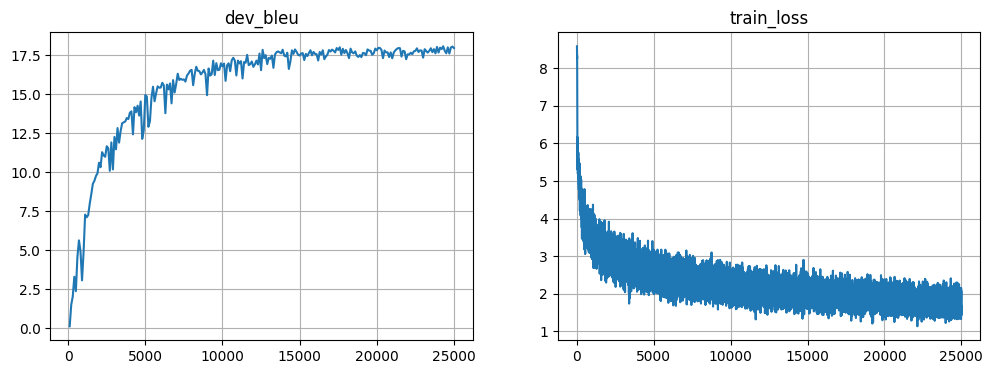

Mean loss=1.658
Mean bleu=17.908


100%|██████████| 25000/25000 [18:17<00:00, 22.78it/s]

CPU times: user 17min 54s, sys: 28.9 s, total: 18min 23s
Wall time: 18min 17s


In [ ]:
model = BaseModel(inp_voc, out_voc).to(device)
%time metrics = traning(model)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

17.967954097599872

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can use shared kitchen facilities and a shared lounge at the property .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers bike hire and car hire are available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
arezzo is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
offering a seasonal outdoor pool , a terrace and a garden , villa del plat@@ a offers a 5 - minute walk from the beach and a 5 - minute drive from the centre of pula .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartments vas@@ na is located in saint petersburg .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathrooms also come with towels .



## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 

        # опишите все слои, которые нужны Attention
        self.activ = torch.tanh

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear = nn.Linear(hid_size, 1)

        self.soft = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """

        # считаем логиты
        batch_size, ninp, enc_size = enc.shape

        temp = self.linear_dec(dec).reshape(-1, 1, self.hid_size)

        x = self.linear_enc(enc)
        x = self.activ(x+temp)
        x = self.linear(x)

        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Примените softmax
        probs = self.soft(x.reshape(batch_size, ninp))

        # Подсчитайте выход attention используя enc состояния и вероятностями
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(axis=1)

        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [ ]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        #nn.Module.__init__(self)
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)     

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size+hid_size, hid_size)
        self.attn = AttentionLayer(hid_size, hid_size, attn_size)

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        
        # делаем encode
        inp_emb = self.emb_inp(inp)
        [dec_start] = super().encode(inp, **flags)    
        enc_seq, next_state = self.enc0(inp_emb) 

        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
        enc_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attn(enc_seq, dec_start, enc_mask)[1]
        
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, enc_seq, enc_mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """

        out_emb = self.emb_out(prev_tokens)

        prev_gru0_state, enc_seq, enc_mask, attn_val = prev_state
        attn_val, attn_prob = self.attn(enc_seq, prev_gru0_state, enc_mask)

        out_emb = torch.cat([attn_val, out_emb], dim=-1)
        out_emb = self.dec0(out_emb, prev_gru0_state)

        output_logits = self.logits(out_emb)
        new_dec_state = [out_emb, enc_seq, enc_mask, attn_prob]

        return [new_dec_state, output_logits]

### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

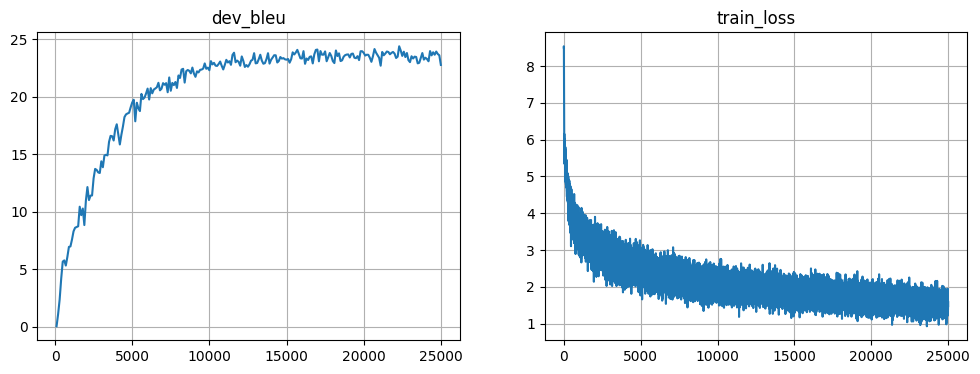

Mean loss=1.517
Mean bleu=23.563


100%|██████████| 25000/25000 [48:18<00:00,  8.63it/s]

CPU times: user 47min 39s, sys: 34.8 s, total: 48min 14s
Wall time: 48min 18s


In [ ]:
attentive_model = AttentiveModel(inp_voc, out_voc).to(device)
%time metrics = traning(attentive_model, lr=1e-3, batch_size=32)

In [ ]:
compute_bleu(attentive_model, dev_inp, dev_out)

22.781334745039153

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 23, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], attentive_model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests have access to shared kitchen and shared living room .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
other facilities like grocery deliveries , a tour desk and free parking are available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
syracuse is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located 5 minutes ’ walk from the beach , beach and a swimming pool , apartment in kuta gardens , a fully equipped kitchen , air conditioning and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
apartments mo@@ nika apartment is located in a quiet side 200 metres from the olympic theatre .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [1]:
!pip install sentencepiece
!pip3 install sacremoses
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=c9de7b816a6ac1c0ff45ee30d31f7249483aa81bd7dd1564aa8ac8350ddc1353
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en", use_fast=False)

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device)

In [16]:
def tokenize(x):
    return ' '.join(WordPunctTokenizer().tokenize(x.lower()))

In [17]:
inp = "я тестирую модель"
input_ids = tokenizer.encode(inp, return_tensors="pt").to(device)
outputs = model.generate(input_ids)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(tokenize(decoded))

i ' m testing the model .


In [ ]:
def compute_blue_transformer(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    inp = [line.replace(bpe_sep, '') for line in inp_lines]
    out = [line.replace(bpe_sep, '') for line in out_lines]
    translations = []
    for src in tqdm(inp):
        input_ids = tokenizer.encode(src, return_tensors="pt").to(device)
        outputs = model.generate(input_ids, max_length=512)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        decoded = tokenize(decoded)
        translations.append(decoded)
        
    return corpus_bleu(
        [[ref.split()] for ref in out],
        [trans.split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
    ) * 100

In [ ]:
compute_blue_transformer(model, dev_inp, dev_out)

100%|██████████| 3000/3000 [15:17<00:00,  3.27it/s]


16.511247671906702

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.3 MB/s eta 0:00:00


In [ ]:
input_ids = []
attention_mask = []
labels = []

for i in range(len(train_inp)):
    tkn = tokenizer(train_inp[i], text_target=train_out[i], truncation=True, padding='max_length', max_length=128)
    input_ids.append(tkn['input_ids'])
    attention_mask.append(tkn['attention_mask'])
    labels.append(tkn['labels'])

input_ids_val = []
attention_mask_val = []
labels_val = []

for i in range(len(dev_inp)):
    tkn = tokenizer(dev_inp[i], text_target=dev_out[i], truncation=True, padding='max_length', max_length=128)
    input_ids_val.append(tkn['input_ids'])
    attention_mask_val.append(tkn['attention_mask'])
    labels_val.append(tkn['labels'])

In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

d = {'train':Dataset.from_dict({'input_ids':input_ids,'attention_mask': attention_mask, 'labels':labels}),
     'val':Dataset.from_dict({'input_ids':input_ids_val,'attention_mask': attention_mask_val, 'labels':labels_val})
     }

ds = DatasetDict(d)

In [ ]:
from transformers import Trainer, TrainingArguments, default_data_collator

In [ ]:
args = TrainingArguments(
    'model_name-finetuned-squad',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=0.5,
    weight_decay=0.01,
    # push_to_hub=True,
)

In [ ]:
data_collator = default_data_collator

trainer = Trainer(
    model,
    args,
    train_dataset=ds['train'],
    eval_dataset=ds['val'],
    tokenizer=tokenizer,
)

In [ ]:
train_data_loader = trainer.get_train_dataloader()

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.442600,0.309133


TrainOutput(global_step=735, training_loss=0.41159123011997767, metrics={'train_runtime': 530.1418, 'train_samples_per_second': 44.329, 'train_steps_per_second': 1.386, 'total_flos': 797289543106560.0, 'train_loss': 0.41159123011997767, 'epoch': 0.5})

In [ ]:
compute_blue_transformer(model, dev_inp, dev_out)

100%|██████████| 3000/3000 [13:40<00:00,  3.66it/s]


33.71030408398176

In [ ]:
<YOUR CODE HERE: compute_bleu>
# аналогично прошлым пунктам

assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 27, "Ты можешь больше! попробуй еще раз)"

Я смогла!